In [44]:
import sqlite3
import pandas

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query= "SELECT name,franchID,yearID,teamID,W,L,G,GHome FROM Teams WHERE yearID>=1985"
salary_query1= "SELECT yearID, teamID, sum(salary) as payroll FROM Salaries GROUP BY yearID, teamID"

team_salaries = pandas.read_sql(salary_query1, conn)
team_info = pandas.read_sql(salary_query, conn)
team_info['WinP'] = (team_info['W']/team_info['G'])*100

##using an innerjoin
prob1 = pandas.DataFrame.merge(team_salaries, team_info, how='inner', left_on=['yearID', 'teamID'], right_on=['yearID', 'teamID'])

team_info[team_info.teamID == 'CAL']

,name,franchID,yearID,teamID,W,L,G,Ghome,WinP
2,California Angels,ANA,1985,CAL,90,72,162,79,55.555556
28,California Angels,ANA,1986,CAL,92,70,162,82,56.790123
54,California Angels,ANA,1987,CAL,75,87,162,81,46.296296
80,California Angels,ANA,1988,CAL,75,87,162,81,46.296296
106,California Angels,ANA,1989,CAL,91,71,162,81,56.172840
132,California Angels,ANA,1990,CAL,80,82,162,81,49.382716
158,California Angels,ANA,1991,CAL,81,81,162,81,50.000000
184,California Angels,ANA,1992,CAL,72,90,162,81,44.444444
210,California Angels,ANA,1993,CAL,71,91,162,81,43.827160
238,California Angels,ANA,1994,CAL,47,68,115,63,40.869565


### Problem 1
For problem 1 I used SQL to get the appropiate data from each table
then used dataframes to preform an inner join in case any data might be missing. So only entries with a matching yearID and teamID from each dataframe are used.
I also used pandas to preform the win percentage computation


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [46]:
payroll = prob1[prob1.yearID >= 1990]
payroll = payroll.sort_values(['teamID', 'yearID'], ascending=[True, True])
##dropping values that older than 1990, and sorting them.

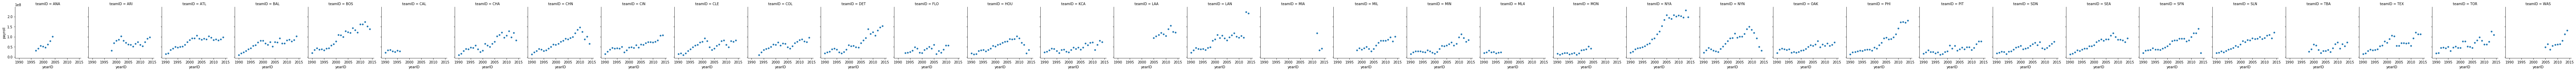

In [47]:
##making the plots for each teams payroll per year.
g = sns.FacetGrid(payroll, col="teamID")
g = g.map(plt.scatter, "yearID", "payroll", edgecolor ="w")

### Question 1
The median payroll increases over time overall.
For most teams, the total payroll increases over time. For other teams it bounces up and down. And in some it increases only to sharply decrease.
Some teams have data b/w 1990 and 2000 only since they may changed names/sold or disbanded.
The spread of the payroll increases with time for some teams. Other teams manage to keep the spread low.

A lot of teams seem to be hit by the recession when their payrolls level off crash and some continue to crash (team could've been invest in industries that did not come back)

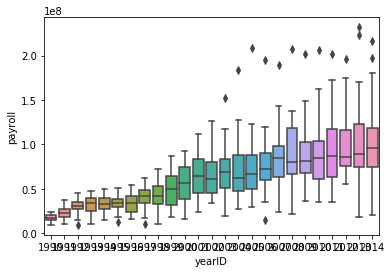

In [48]:
g1 = sns.boxplot(x="yearID", y="payroll", data=payroll)

### Problem 3
the y-axis is payroll times 10^8, and the x-axis is yearID

As seen in the box and whisker plot, the median pay tends to increase over time.

In [49]:
prob4 = prob1

##defining bins starting in 1984 instead of 1990 so that It can be used for analysis later on.
bins = [1984, 1990, 1996, 2002, 2008, 2014]
group_names = ['1985-1990', '1991-1996', '1997-2002', '2003-2008', '2009-2014']

## see next problem6 code, same comments. It cuts based on yearID that falls within the right bin.
prob4['period'] = pandas.cut(prob4['yearID'], bins, labels=group_names)
dfs = [None]*len(group_names)

for index in range(len(group_names)):
    dfs[index] = prob4[prob4.period == [group_names[index]]]
    dfs[index] = dfs[index].groupby(['teamID']).mean()

## making a helper function to label the dataplots. see later notes for explanation
def annotate_teams(df):
    for label, x, y in zip(df.index.values, df['payroll'], df['WinP']):
        plt.annotate(
            label,
            xy = (x, y), 
            xytext = (0, 15),
            textcoords = 'offset points', 
            ha = 'right', 
            va = 'bottom',
            bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha=0.75),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )

#### 1985-1990

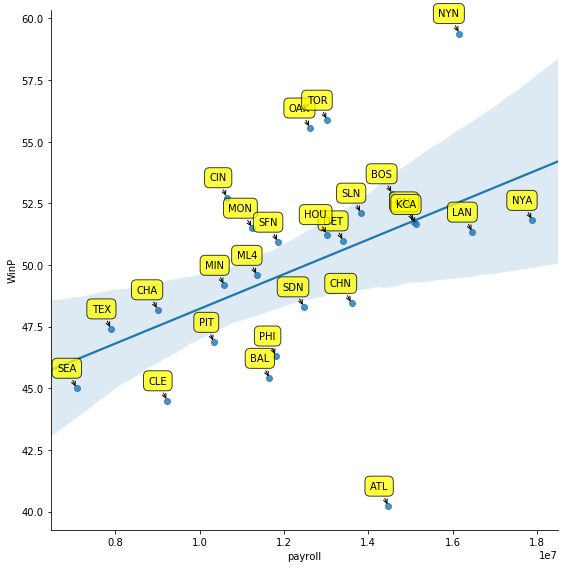

In [50]:
g2 = sns.lmplot(x='payroll',y='WinP',data=dfs[0],fit_reg=True, size=8) 
annotate_teams(dfs[0])

#### 1991-1996

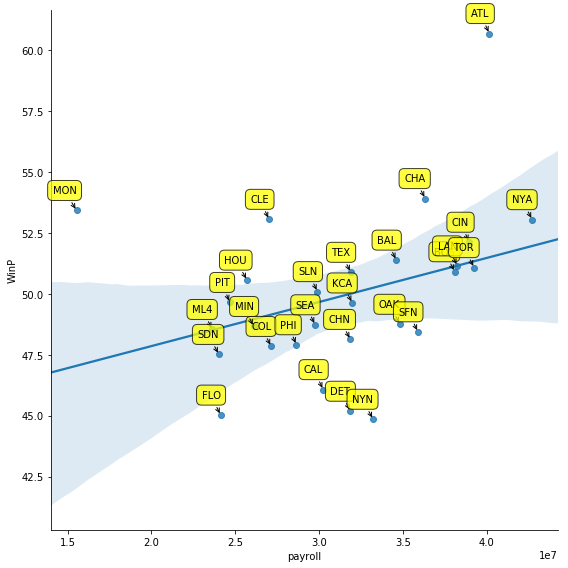

In [51]:
g3 = sns.lmplot(x='payroll',y='WinP',data=dfs[1],fit_reg=True, size=8) 
annotate_teams(dfs[1])

#### 1997-2002

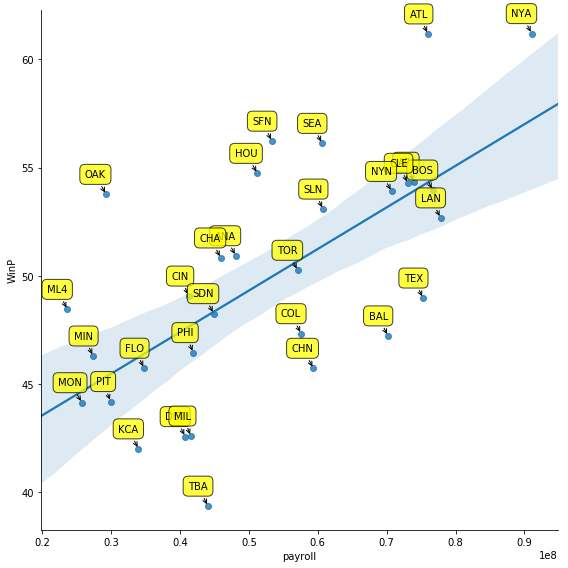

In [52]:
g4 = sns.lmplot(x='payroll',y='WinP',data=dfs[2],fit_reg=True, size=8) 
annotate_teams(dfs[2])

#### 2003-2008

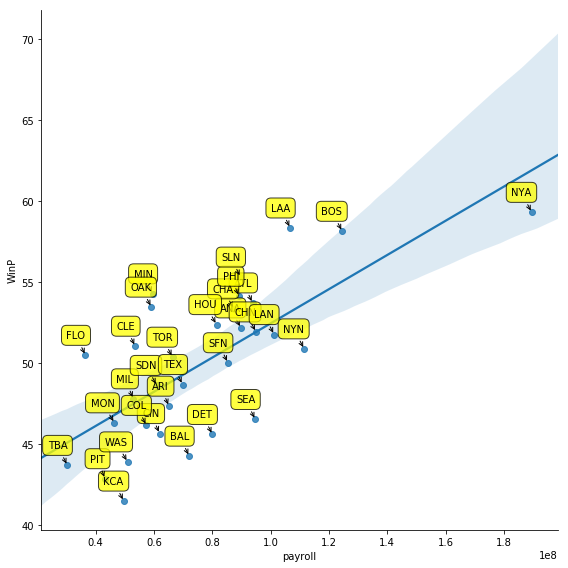

In [53]:
g5 = sns.lmplot(x='payroll',y='WinP',data=dfs[3],fit_reg=True, size=8) 
annotate_teams(dfs[3])

### 2009 - 2014

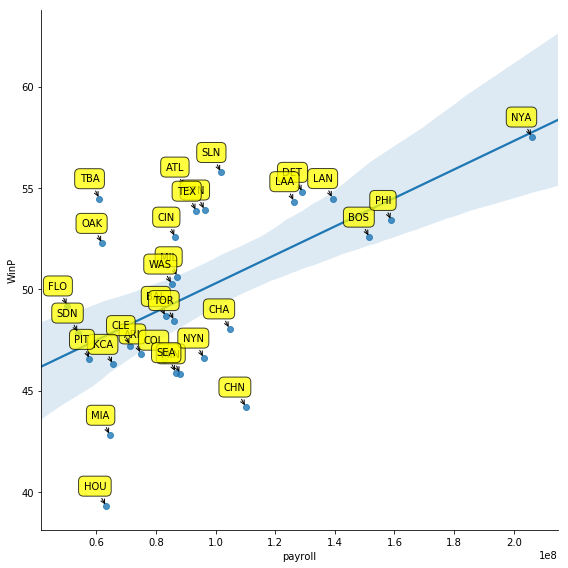

In [55]:
g6 = sns.lmplot(x='payroll',y='WinP',data=dfs[4],fit_reg=True, size=8) 
annotate_teams(dfs[4])

#### Question 2

The x-axis is win percentage, the y-axis is the payroll times 10^8

From 1990-1995, 2002-2014 the spread in payroll is almost consistent.
From 1991-1996 the spread of payroll for all teams is up by almost 200million
From 1997-2002 this high payroll readjusted and spread of all payrolls are down by almost 100million.

These changes coincide with dotcom bubble forming and popping.

The New York Yankees (of course) always pay the highest amount and also always seems to win the most. (BOOOO)

Based on Moneyball story, we can see that pre-1997 OAK did not have a consistently low pay with consistenly high win percentage.
Starting in 1997, (includes 2002) we can see that OAK has a high WinP (almost 50% or better) while staying relatively low pay combared with other teams.

In [54]:
## prob5_query is using SQL to do an innerjoin of payroll per team per year
## total_payroll_query is using SQL to find the total payroll for all teams per year

prob5_query = "with total_payroll as (SELECT teamID, yearID, sum(salary) as payroll FROM Salaries GROUP BY teamID, yearID) SELECT Teams.teamID, Teams.yearID, payroll, ((W*1.0/G)*100) as WinP FROM total_payroll, Teams WHERE total_payroll.yearID = Teams.yearID and total_payroll.teamID = Teams.teamID"
total_payroll_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID"
total_payroll = pandas.read_sql(total_payroll_query, conn)
prob5 = pandas.read_sql(prob5_query, conn)

##Using apply and anonomyous function to compute the standard deviation and the mean of payrolls per year.
total_payroll['std'] = total_payroll.apply(lambda row: prob5[prob5['yearID'] == row['yearID']]['payroll'].std(), axis = 1)
total_payroll['avg'] = total_payroll.apply(lambda row: prob5[prob5['yearID'] == row['yearID']]['payroll'].mean(), axis = 1)
##I do this so my next anonymous function works
total_payroll = total_payroll.set_index(['yearID'])
##I now cacluate the standard payroll
prob5['Standardized Payroll'] = prob5.apply(lambda row: (row['payroll'] - total_payroll.loc[row['yearID']]['avg'])/(total_payroll.loc[row['yearID']]['std']), axis=1)
prob5
#total_payroll

,teamID,yearID,payroll,WinP,Standardized Payroll
0,ATL,1985,14807000.0,40.740741,1.914905
1,BAL,1985,11560712.0,51.552795,0.601068
2,BOS,1985,10897560.0,49.693252,0.332678
3,CAL,1985,14427894.0,55.555556,1.761474
4,CHA,1985,9846178.0,52.147239,-0.092838
5,CHN,1985,12702917.0,47.530864,1.063341
6,CIN,1985,8359917.0,54.938272,-0.694357
7,CLE,1985,6551666.0,37.037037,-1.426192
8,DET,1985,10348143.0,52.173913,0.110318
9,HOU,1985,9993051.0,51.234568,-0.033395


In [56]:
prob6 = prob5
### Using cut to break the data up into 5 periods. The same as from problem 4
prob6['period'] = pandas.cut(prob6['yearID'], bins, labels=group_names)

###Make a dataframe for the number of bins
dfs1 = [None]*len(group_names)

###Find the 
for index in range(len(group_names)):
    dfs1[index] = prob6[prob6.period == [group_names[index]]]
    dfs1[index] = dfs1[index].groupby(['teamID']).mean()
    
def annotate_teams2(df):
##zip creates an iterator
    for label, x, y in zip(df.index.values, df['Standardized Payroll'], df['WinP']):
        ##annotating each datapoint
        plt.annotate(
            label,
            xy = (x, y), 
            xytext = (0, 15),
            textcoords = 'offset points', 
            ha = 'right', 
            va = 'bottom',
            bbox = dict(boxstyle = 'round, pad=0.5', fc = 'yellow', alpha=0.75),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )


#### The plots

the y-axis is the win percentage
the x-axis is the standarized payroll

#### 1985-1990

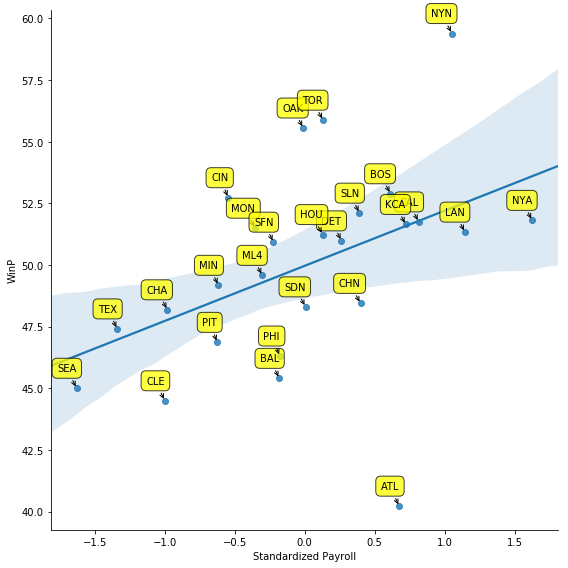

In [57]:
g2 = sns.lmplot(x='Standardized Payroll',y='WinP',data=dfs1[0],fit_reg=True, size=8) 
annotate_teams2(dfs1[0])

#### 1991 - 1996

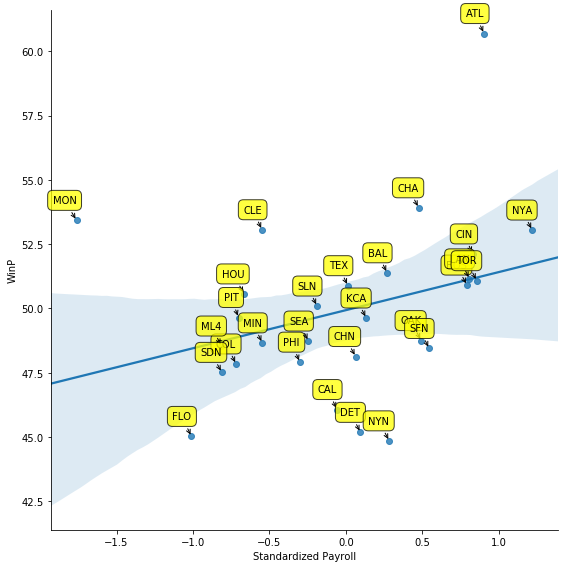

In [58]:
g2 = sns.lmplot(x='Standardized Payroll',y='WinP',data=dfs1[1],fit_reg=True, size=8) 
annotate_teams2(dfs1[1])

#### 1997 - 2002

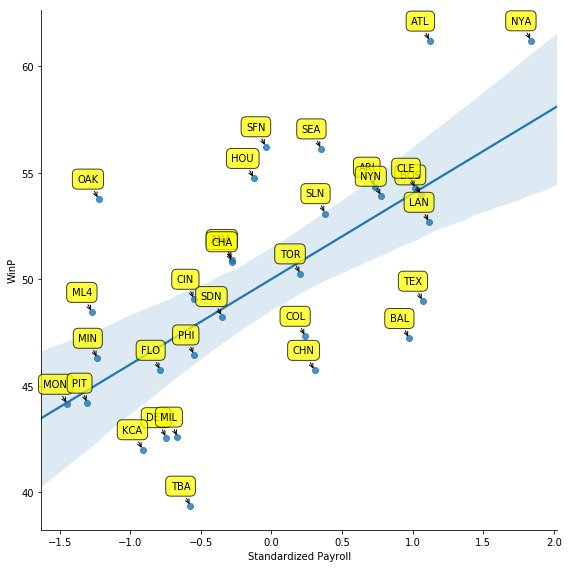

In [65]:
g2 = sns.lmplot(x='Standardized Payroll',y='WinP',data=dfs1[2],fit_reg=True, size=8) 
annotate_teams2(dfs1[2])

#### 2003 - 2008

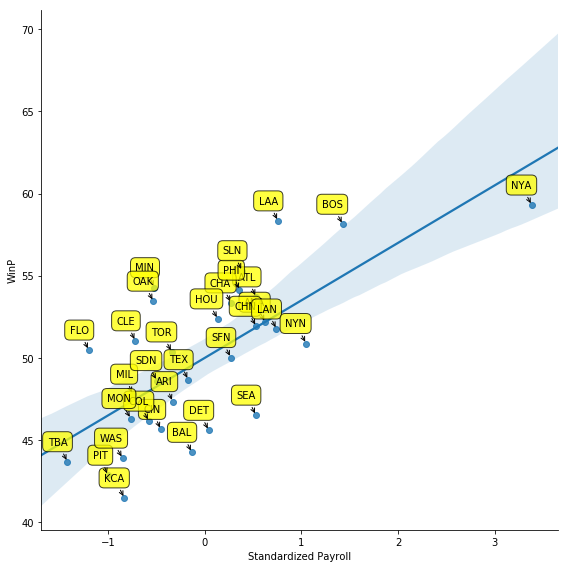

In [59]:
g2 = sns.lmplot(x='Standardized Payroll',y='WinP',data=dfs1[3],fit_reg=True, size=8) 
annotate_teams2(dfs1[3])

#### 2009 - 2014

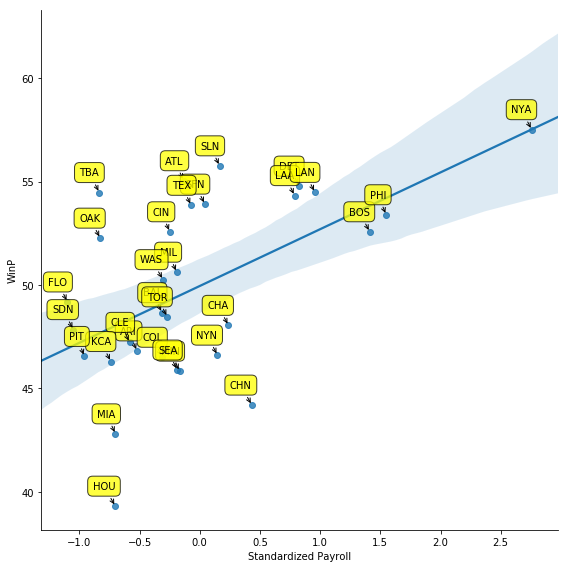

In [67]:
g2 = sns.lmplot(x='Standardized Payroll',y='WinP',data=dfs1[4],fit_reg=True, size=8) 
annotate_teams2(dfs1[4])

#### Question 3

The plots from problem 4 to problem 6 reflect the transformation by the fact teams do not change their relative locations on the graph.

THe new x-axis now tells us tho who pays the average for the time period, and who pays above the average.


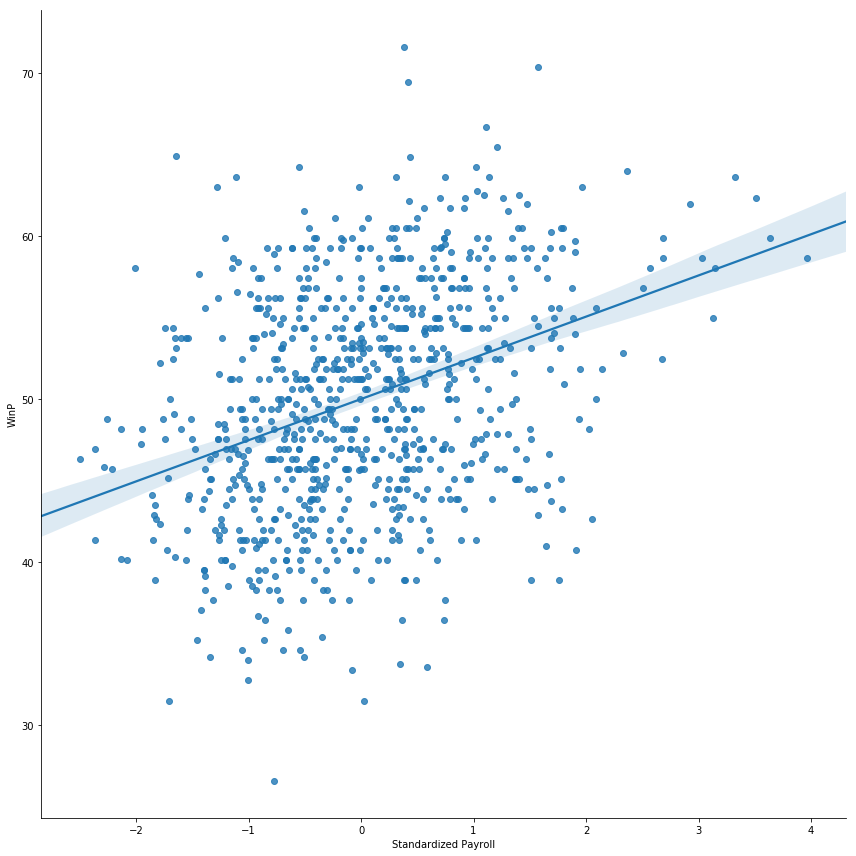

In [66]:
g = sns.lmplot(x='Standardized Payroll',y='WinP',data=prob5,fit_reg=True, size=12)

In [61]:
prob7 = prob6
## using apply and anonymous function to compute a new row, using existing rows.
prob7['expected_WinP'] = prob7.apply(lambda row: row['Standardized Payroll'] * 2.5 + 50, axis=1)
prob7['efficiency'] = prob7.apply(lambda row: row['WinP'] - row['expected_WinP'], axis=1)
prob7

,teamID,yearID,payroll,WinP,Standardized Payroll,period,expected_WinP,efficiency
0,ATL,1985,14807000.0,40.740741,1.914905,1985-1990,54.787263,-14.046522
1,BAL,1985,11560712.0,51.552795,0.601068,1985-1990,51.502671,0.050124
2,BOS,1985,10897560.0,49.693252,0.332678,1985-1990,50.831694,-1.138442
3,CAL,1985,14427894.0,55.555556,1.761474,1985-1990,54.403684,1.151872
4,CHA,1985,9846178.0,52.147239,-0.092838,1985-1990,49.767906,2.379333
5,CHN,1985,12702917.0,47.530864,1.063341,1985-1990,52.658353,-5.127489
6,CIN,1985,8359917.0,54.938272,-0.694357,1985-1990,48.264108,6.674164
7,CLE,1985,6551666.0,37.037037,-1.426192,1985-1990,46.434521,-9.397484
8,DET,1985,10348143.0,52.173913,0.110318,1985-1990,50.275794,1.898119
9,HOU,1985,9993051.0,51.234568,-0.033395,1985-1990,49.916512,1.318056


In [60]:
##Making a helper functino to plot year_vs_efficiency

def year_vs_efficiency(str):
##it works based on the teamID I enter
    prob7[prob7['teamID'] == str].plot(x='yearID', y='efficiency')
##zip creates iterable objects for my for loops, so that I can annotate my graph to make it easier to understand
    for label, x, y in zip(prob7[prob7['teamID'] == str]['yearID'], prob7[prob7['teamID'] == str]['yearID'], prob7[prob7['teamID'] == str]['efficiency']):
        plt.annotate(
            label,
            xy = (x, y), 
            xytext = (0, 10),
            textcoords = 'offset points', 
            ha = 'right', 
            va = 'bottom',
            bbox = dict(boxstyle = 'round, pad=0.3', fc = 'yellow', alpha=0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
        )
    ## this command will print the graph
    plt.show 

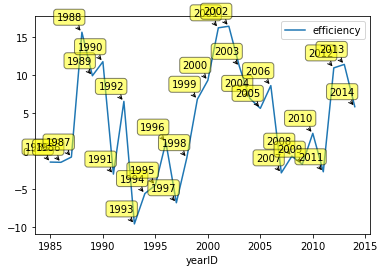

In [64]:
year_vs_efficiency('OAK')

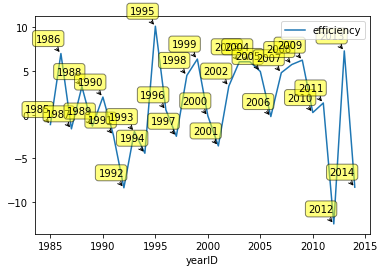

In [63]:
year_vs_efficiency('BOS')

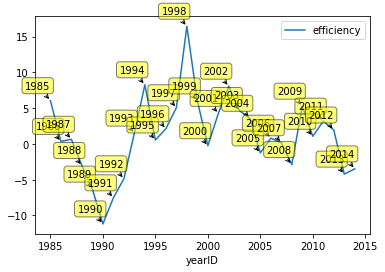

In [62]:
year_vs_efficiency('NYA')

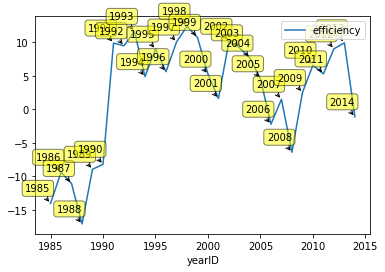

In [69]:
year_vs_efficiency('ATL')

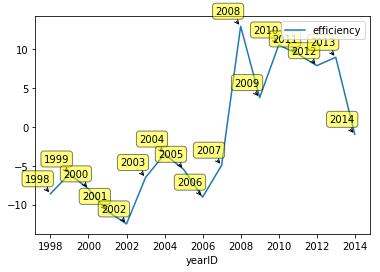

In [68]:
year_vs_efficiency('TBA')

#### Question 4

The y-axis is Effeciency, the x-axis is year.

From the effeciency plots we can learn even better what teams are the best at spending less money while still winning. In the plots from question 2 and 3 we can only get an idea of how good teams are at winning per average payroll over a period. However, it does not say if they were necesarrily effecient spenders, just that they may be.

During the Moneyball period and leading up to it, OAK became more and more effecient at spending less money to win. Post 2002 they managed to remain mostly effecient.
Teams like the Yankees are actually not as effecient compared to other relatively high-spenders like the Braves.